## Comparison of Annotators

In these notebook we compare how different human annotators assigned image pixels to different classes.

In [1]:
# Import basic packages
import numpy as np 
import scipy as scipy 
import os
import sys
import json
import datetime
from PIL import Image
import skimage.draw
import numpy.ma as ma
import imageio

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.gridspec as gridspec
from SecretColors import Palette
from SecretColors import ColorMap

%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [2]:
# Common core
common_cores = ["common_core_Dimitrios.json","common_core_AlexC.json","common_core_AlexDW.json","common_core_Ariel.json",
        "common_core_Sydney.json","common_core_diana.json","common_core_jackie.json","common_core_kathryn.json"]

n_annots = len(common_cores) # Number of annotators

# Let's print the number of annotators
print(n_annots)

8


In [3]:
# Define function that creates mask for the Ghosts
def masking(regions,n_ghosts):
    
    """
    Inputs:

    Outputs:

    """
    #Initialize three different masks - one for each type of ghosts
    X_mask_rays = np.zeros([400,400])
    X_mask_bright = np.zeros([400,400])
    X_mask_faint = np.zeros([400,400])
    # And one that does not distinguish between the ghost types
    X_mask_any = np.zeros([400,400])

    for k in range(n_ghosts):
        regions_loc = regions[k]

        # ==========================================
        # ==========================================
        # First get ghost types
        Type_loc = regions_loc['region_attributes']['Type']

        # Get shape attributes
        shape_attrs = regions_loc['shape_attributes']

        # Get the name of the shape attribute
        name = shape_attrs['name']
        # =====================================================
        # =====================================================
    
        if (name=='polyline'):
            rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
            a = (rr<400)&(cc<400)
        elif (name=='polygon'):
            rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
            a = (rr<400)&(cc<400)
        elif (name=='rect'):
            rr, cc = skimage.draw.rectangle(start=(shape_attrs['y'], shape_attrs['x']),
                              extent=(shape_attrs['height'],shape_attrs['width']))
            a = (rr<400)&(cc<400)
        elif (name=='circle'):
            rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])
            a = (rr<400)&(cc<400)
        elif (name=='ellipse'): 
            rr, cc = skimage.draw.ellipse(shape_attrs['cy'],shape_attrs['cx'],
                                      shape_attrs['ry'],shape_attrs['rx'],
                                      shape=None,rotation=-shape_attrs['theta'])
            a = (rr<400)&(cc<400)
        # ========================================================
        # ========================================================
        if (Type_loc=='Rays'):
            X_mask_rays[rr[a], cc[a]] = 1.
        elif (Type_loc=='Bright'):
            X_mask_bright[rr[a], cc[a]] = 1.
        elif (Type_loc=='Faint'):
            X_mask_faint[rr[a], cc[a]] = 1.
            
        # For any type of ghosts
        X_mask_any[rr[a],cc[a]] = 1.

        # ===========================================================
  
    # We return the 2D arrays now
    return X_mask_rays, X_mask_bright, X_mask_faint,X_mask_any

In [4]:
# Initialize matrices
X_rays_tot = np.zeros([50,400,400]) # For Rays
X_bright_tot = np.zeros([50,400,400]) # For bright
X_faint_tot = np.zeros([50,400,400]) # For faint
X_any_tot = np.zeros([50,400,400]) # This is for any type of ghosts


# Run over annotators
for i in range(n_annots):
    # Annotator i
    common_core_local = common_cores[i]
    
    #print(common_core_local)
    # =================================
    # Load annotations
    
    annotations_loc = json.load(open(common_core_local))
    annotations = list(annotations_loc['_via_img_metadata'].values())
    annotations = [a for a in annotations if a['regions']]
   
    # ================================
    # Print the number of images
    n_img = len(annotations)
    
    # =======================================================
    # =======================================================
    # Run over images
    for j in range(n_img):
        # Get the annotations of the j-th image
        img_annotations = annotations[j]
        
        # Get regions - pretty much the description of the annotations
        regions = img_annotations['regions']
        # Now get the number of ghosts
        n_ghosts = len(regions)
        
        # Get rays, bright, faint masks - pretty much "1" in the spots
        # where there is a ghost
        X_rays, X_bright, X_faint, X_any = masking(regions,n_ghosts)
        
        # Update the matrices
        X_rays_tot[j,:,:] += X_rays
        X_bright_tot[j,:,:] += X_bright
        X_faint_tot[j,:,:] += X_faint
        X_any_tot[j,:,:] += X_any
    
    

<ipython-input-3-4e1bd3ffe7d5>:44: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])


In [5]:
X_rays_flat = X_rays_tot.flatten()
X_bright_flat = X_bright_tot.flatten()
X_faint_flat = X_faint_tot.flatten()

print(np.max(X_faint_flat))

8.0


In [6]:
print(np.max(X_faint_flat[X_faint_flat>0]))

8.0


### Histograms of pixel values

- Rays

In [7]:
bins_def = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]

# Defines proportions of box
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

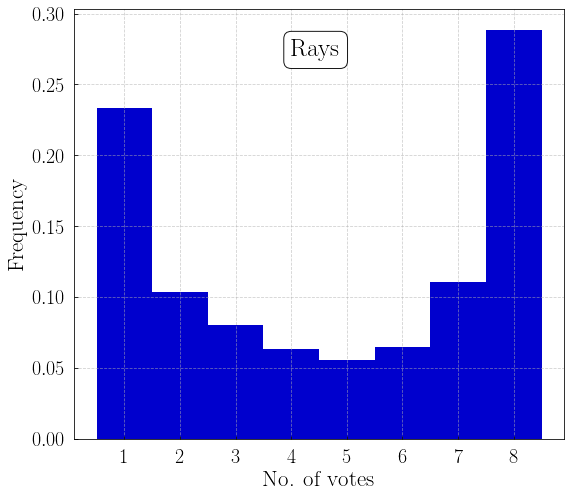

In [8]:
plt.figure(figsize=(8, 7))


plt.hist(X_rays_flat[X_rays_flat>0],bins=bins_def,color='mediumblue',density=True)
plt.text(4,0.27, r'Rays',bbox=props, color='k',fontsize=25)

# Legents / labels etc
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=20)
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel("No. of votes", fontsize=23)
plt.ylabel("Frequency", fontsize=23)

plt.tight_layout()
plt.savefig('Rays_dist.pdf')
plt.show()

- Bright

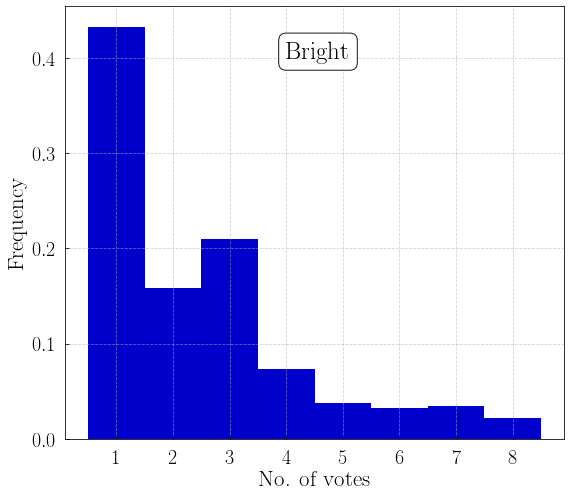

In [9]:
plt.figure(figsize=(8, 7))


plt.hist(X_bright_flat[X_bright_flat>0],bins=bins_def,color='mediumblue',density=True)
plt.text(4,0.40, r'Bright',bbox=props, color='k',fontsize=25)

# Legents / labels etc
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=20)
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel("No. of votes", fontsize=23)
plt.ylabel("Frequency", fontsize=23)


plt.tight_layout()
plt.savefig('Bright_dist.pdf')
plt.show()

- Faint 

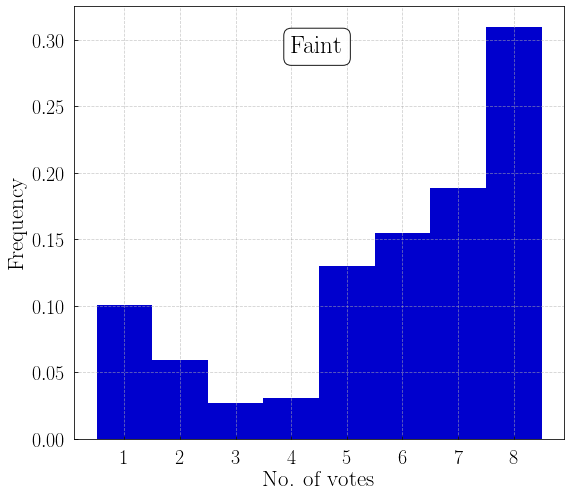

In [10]:
plt.figure(figsize=(8, 7))


plt.hist(X_faint_flat[X_faint_flat>0],bins=bins_def,color='mediumblue',density=True)
plt.text(4,0.29, r'Faint',bbox=props, color='k',fontsize=25)


# Legents / labels etc
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=20)
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel("No. of votes", fontsize=23)
plt.ylabel("Frequency", fontsize=23)


plt.tight_layout()
plt.savefig('Faint_dist.pdf')
plt.show()

### Overplot masks for a few images

In [11]:
annotations_loc = json.load(open("common_core_Dimitrios.json"))
annotations = list(annotations_loc['_via_img_metadata'].values())
annotations = [a for a in annotations if a['regions']]

i = 35
img_annotations = annotations[i]
# Get filename
filename = img_annotations['filename']
print(filename)
# Get image 
image = Image.open(filename)

Ghost_img_D00409444.jpg


In [12]:
X_mask_rays = ma.masked_where(X_rays_tot[i,:,:]<1, X_rays_tot[i,:,:])
X_mask_bright = ma.masked_where(X_bright_tot[i,:,:]<1, X_bright_tot[i,:,:])
X_mask_faint = ma.masked_where(X_faint_tot[i,:,:]<1, X_faint_tot[i,:,:])

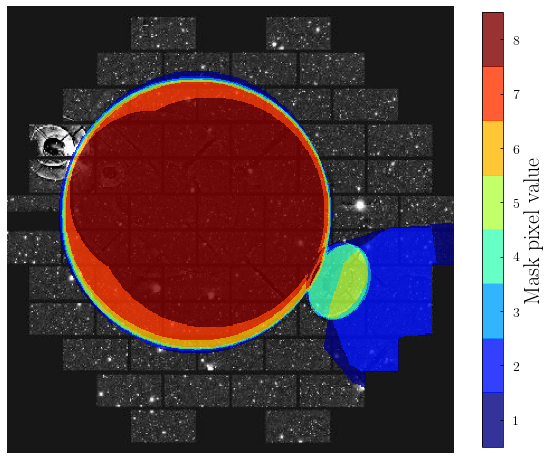

In [13]:
plot_pretty() 
plt.figure(figsize=(10, 10))

cmap_jet = plt.cm.jet
# define the bins and normalize
bounds = np.linspace(0.5, 8.5, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap_jet.N)

plt.imshow(image,cmap='gray')
#plt.imshow(X_mask_bright,cmap=cmap_jet,norm=norm,alpha=0.8)
plt.imshow(X_mask_faint,cmap=cmap_jet, norm=norm,alpha=0.8)


cbar = plt.colorbar(ticks=[1,2,3,4,5,6,7,8],shrink=0.80)
cbar.set_label('Mask pixel value', fontsize=22)
cbar.ax.set_yticklabels([1,2,3,4,5,6,7,8], fontsize=14)


plt.axis('off')
#plt.savefig('Overlap.pdf')
plt.show()

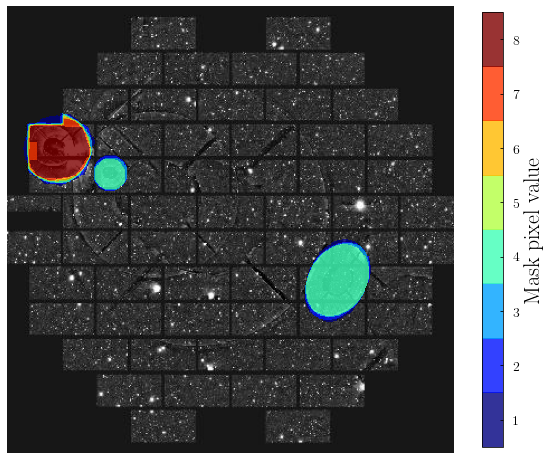

In [14]:
plt.figure(figsize=(10, 10))

cmap_jet = plt.cm.jet
# define the bins and normalize
bounds = np.linspace(0.5, 8.5, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap_jet.N)

plt.imshow(image,cmap='gray')
plt.imshow(X_mask_bright,cmap=cmap_jet,norm=norm,alpha=0.8)
#plt.imshow(X_mask_faint,cmap=cmap_jet, norm=norm,alpha=0.8)


cbar = plt.colorbar(ticks=[1,2,3,4,5,6,7,8],shrink=0.80)
cbar.set_label('Mask pixel value', fontsize=22)
cbar.ax.set_yticklabels([1,2,3,4,5,6,7,8], fontsize=14)


plt.axis('off')
#plt.savefig('Bright_masks.pdf')
plt.show()

### Now without distinguishing between different types of ghosts

**Start with a histogram**

In [15]:
X_any_flat = X_any_tot.flatten()

print(len(X_any_flat[X_any_flat==8])/len(X_any_flat[X_any_flat>0]))

0.4422414377776271


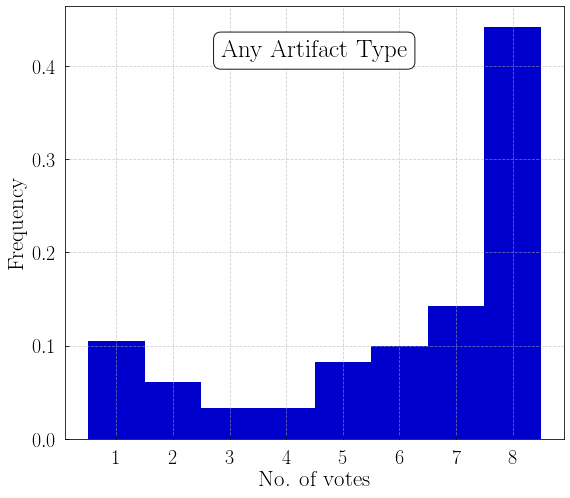

In [16]:
plt.figure(figsize=(8, 7))


plt.hist(X_any_flat[X_any_flat>0],bins=bins_def,color='mediumblue',density=True)
plt.text(2.85,0.41, r'Any Artifact Type',bbox=props, color='k',fontsize=25)


# Legents / labels etc
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=20)
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel("No. of votes", fontsize=23)
plt.ylabel("Frequency", fontsize=23)


plt.tight_layout()
plt.savefig('Any_ghost_dist.pdf')
plt.show()

#### Plot of ghosts

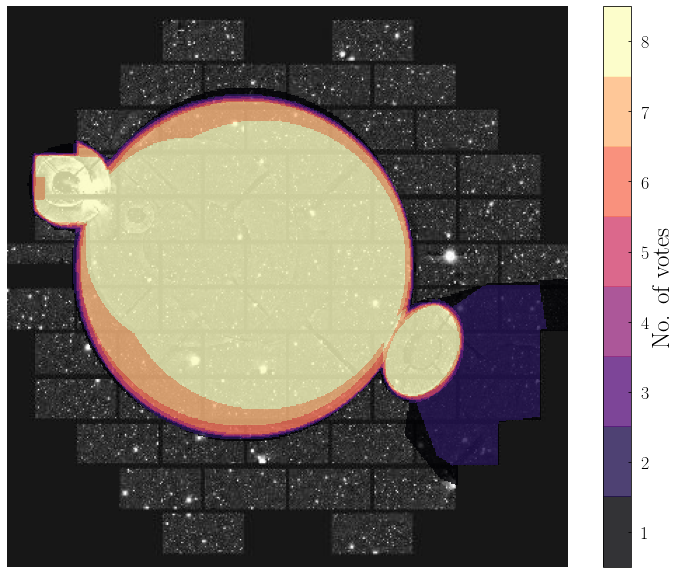

In [17]:
X_mask_any = ma.masked_where(X_any_tot[i,:,:]<1, X_any_tot[i,:,:])


plot_pretty() 
plt.figure(figsize=(10, 10))

# colormap
cmap_magma = plt.cm.magma

# define the bins and normalize
bounds = np.linspace(0.5, 8.5, 9)
norm = mpl.colors.BoundaryNorm(bounds,  cmap_magma.N)


plt.imshow(image,cmap='gray')


plt.imshow(X_mask_any,cmap=cmap_magma,norm=norm,alpha=0.8)

cbar = plt.colorbar(ticks=[1,2,3,4,5,6,7,8],shrink=0.80)
cbar.set_label('No. of votes', fontsize=25)
cbar.ax.set_yticklabels([1,2,3,4,5,6,7,8], fontsize=18)

plt.axis('off')
plt.tight_layout()
plt.savefig('Overlap_Any_ghost.pdf')
plt.show()

### Make similar plots for another figure - this time containing a ray

In [18]:
i = 39
img_annotations = annotations[i]
# Get filename
filename = img_annotations['filename']
print(filename)
# Get image 
image = Image.open(filename)

Ghost_img_D00239420.jpg


In [19]:
X_mask_rays = ma.masked_where(X_rays_tot[i,:,:]<1, X_rays_tot[i,:,:])
X_mask_bright = ma.masked_where(X_bright_tot[i,:,:]<1, X_bright_tot[i,:,:])
X_mask_faint = ma.masked_where(X_faint_tot[i,:,:]<1, X_faint_tot[i,:,:])
X_mask_any = ma.masked_where(X_any_tot[i,:,:]<1, X_any_tot[i,:,:])

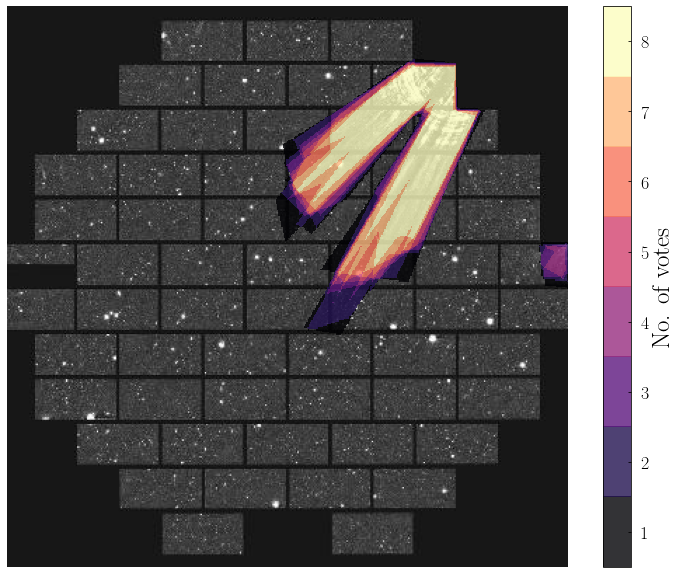

In [20]:
plt.figure(figsize=(10, 10))


cmap_viridis = plt.cm.magma
colorMap = ColorMap(mpl, Palette("ibm"))
# define the bins and normalize
bounds = np.linspace(0.5, 8.5, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap_magma.N)

plt.imshow(image,cmap='gray')
plt.imshow(X_mask_rays,cmap=cmap_magma, norm=norm,alpha=0.8)

cbar = plt.colorbar(ticks=[1,2,3,4,5,6,7,8],shrink=0.80)
cbar.set_label('No. of votes', fontsize=25)
cbar.ax.set_yticklabels([1,2,3,4,5,6,7,8], fontsize=18)


plt.axis('off')
plt.tight_layout()
plt.savefig('Overlap_rays.pdf')
plt.show()